# Mood-Based Playlist Generator: A Music Recommendation System

* Build a playlist recommendation system that suggests songs based on mood categories
* Use clustering models to group songs by mood, leveraging acoustic features (valence, energy, tempo).
* Personalize playlists by allowing users to input their mood, and get dynamic song recommendations.

# Business Understanding

# Data Understanding

In [66]:
pip install scikit-fuzzy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from textblob import TextBlob
import ipywidgets as widgets
from IPython.display import display
from sklearn.metrics import silhouette_score
import skfuzzy as fuzz
from sklearn.decomposition import PCA

# Suppress future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning) 

In [72]:
df=pd.read_csv('./df_with_genres.csv')
df

,Unnamed: 0,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target,song_title,artist,genre
0,0,0.01020,0.833,204600,0.434,0.021900,2,0.1650,-8.795,1,0.4310,150.062,4.0,0.286,1,Mask Off,Future,rap
1,1,0.19900,0.743,326933,0.359,0.006110,1,0.1370,-10.401,1,0.0794,160.083,4.0,0.588,1,Redbone,Childish Gambino,NaN
2,2,0.03440,0.838,185707,0.412,0.000234,2,0.1590,-7.148,1,0.2890,75.044,4.0,0.173,1,Xanny Family,Future,rap
3,3,0.60400,0.494,199413,0.338,0.510000,5,0.0922,-15.236,1,0.0261,86.468,4.0,0.230,1,Master Of None,Beach House,dream pop
4,4,0.18000,0.678,392893,0.561,0.512000,5,0.4390,-11.648,0,0.0694,174.004,4.0,0.904,1,Parallel Lines,Junior Boys,"alternative dance, indie electronic"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012,2012,0.00106,0.584,274404,0.932,0.002690,1,0.1290,-3.501,1,0.3330,74.976,4.0,0.211,0,Like A Bitch - Kill The Noise Remix,Kill The Noise,"dubstep, melodic bass, edm"
2013,2013,0.08770,0.894,182182,0.892,0.001670,1,0.0528,-2.663,1,0.1310,110.041,4.0,0.867,0,Candy,Dillon Francis,"moombahton, edm, electro house"
2014,2014,0.00857,0.637,207200,0.935,0.003990,0,0.2140,-2.467,1,0.1070,150.082,4.0,0.470,0,Habit - Dack Janiels & Wenzday Remix,Rain Man,future bass
2015,2015,0.00164,0.557,185600,0.992,0.677000,1,0.0913,-2.735,1,0.1330,150.011,4.0,0.623,0,First Contact,Twin Moons,dubstep


In [73]:
df.columns

Index(['Unnamed: 0', 'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'valence', 'target',
       'song_title', 'artist', 'genre'],
      dtype='object')

In [4]:
df.shape

(2017, 17)

In [11]:
df.describe()

,Unnamed: 0,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target
count,2017.000000,2017.000000,2017.000000,2.017000e+03,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000
mean,1008.000000,0.187590,0.618422,2.463062e+05,0.681577,0.133286,5.342588,0.190844,-7.085624,0.612295,0.092664,121.603272,3.968270,0.496815,0.505702
std,582.402066,0.259989,0.161029,8.198181e+04,0.210273,0.273162,3.648240,0.155453,3.761684,0.487347,0.089931,26.685604,0.255853,0.247195,0.500091
min,0.000000,0.000003,0.122000,1.604200e+04,0.014800,0.000000,0.000000,0.018800,-33.097000,0.000000,0.023100,47.859000,1.000000,0.034800,0.000000
25%,504.000000,0.009630,0.514000,2.000150e+05,0.563000,0.000000,2.000000,0.092300,-8.394000,0.000000,0.037500,100.189000,4.000000,0.295000,0.000000
50%,1008.000000,0.063300,0.631000,2.292610e+05,0.715000,0.000076,6.000000,0.127000,-6.248000,1.000000,0.054900,121.427000,4.000000,0.492000,1.000000
75%,1512.000000,0.265000,0.738000,2.703330e+05,0.846000,0.054000,9.000000,0.247000,-4.746000,1.000000,0.108000,137.849000,4.000000,0.691000,1.000000
max,2016.000000,0.995000,0.984000,1.004627e+06,0.998000,0.976000,11.000000,0.969000,-0.307000,1.000000,0.816000,219.331000,5.000000,0.992000,1.000000


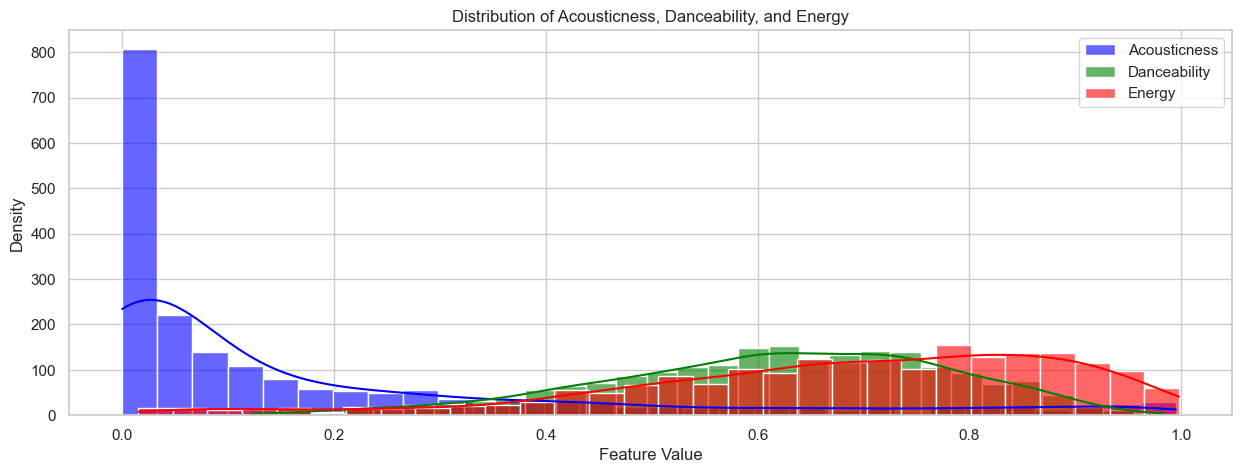

In [75]:
# Set visualization style
sns.set(style="whitegrid")

# Plot distributions
plt.figure(figsize=(15, 5))
sns.histplot(df["acousticness"], bins=30, kde=True, color="blue", label="Acousticness", alpha=0.6)
sns.histplot(df["danceability"], bins=30, kde=True, color="green", label="Danceability", alpha=0.6)
sns.histplot(df["energy"], bins=30, kde=True, color="red", label="Energy", alpha=0.6)
plt.legend()
plt.title("Distribution of Acousticness, Danceability, and Energy")
plt.xlabel("Feature Value")
plt.ylabel("Density")
plt.show()

### Visualize Distribution of Artists and Songs

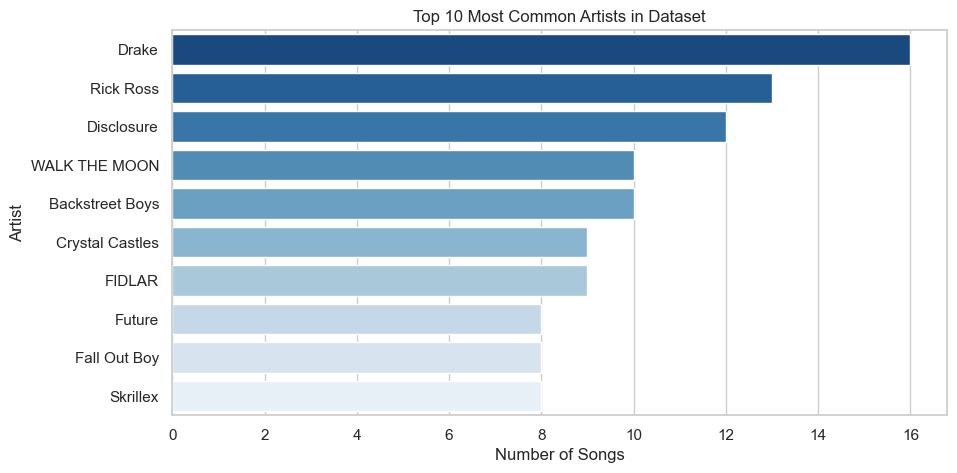

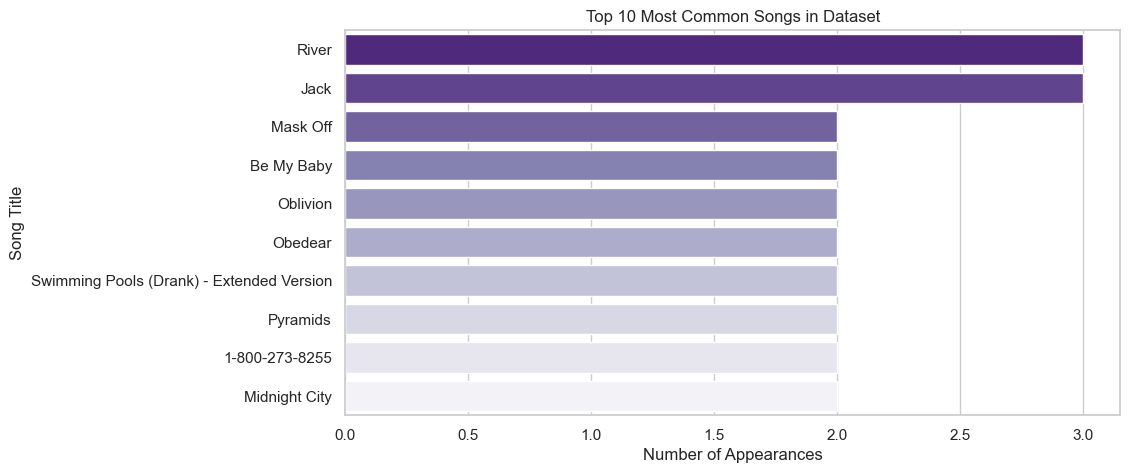

In [77]:
# Count top 10 most common artists
top_artists = df["artist"].value_counts().head(10)

# Count top 10 most common songs
top_songs = df["song_title"].value_counts().head(10)

# Plot top 10 artists
plt.figure(figsize=(10, 5))
sns.barplot(y=top_artists.index, x=top_artists.values, palette="Blues_r")
plt.title("Top 10 Most Common Artists in Dataset")
plt.xlabel("Number of Songs")
plt.ylabel("Artist")
plt.show()

# Plot top 10 songs
plt.figure(figsize=(10, 5))
sns.barplot(y=top_songs.index, x=top_songs.values, palette="Purples_r")
plt.title("Top 10 Most Common Songs in Dataset")
plt.xlabel("Number of Appearances")
plt.ylabel("Song Title")
plt.show()


# Data Preparation

### Drop Unnamed and Target columns

In [74]:
# Drop Unnamed and Target columns
df = df.drop(columns=["Unnamed: 0", "target"], errors="ignore")

### Correlation between features

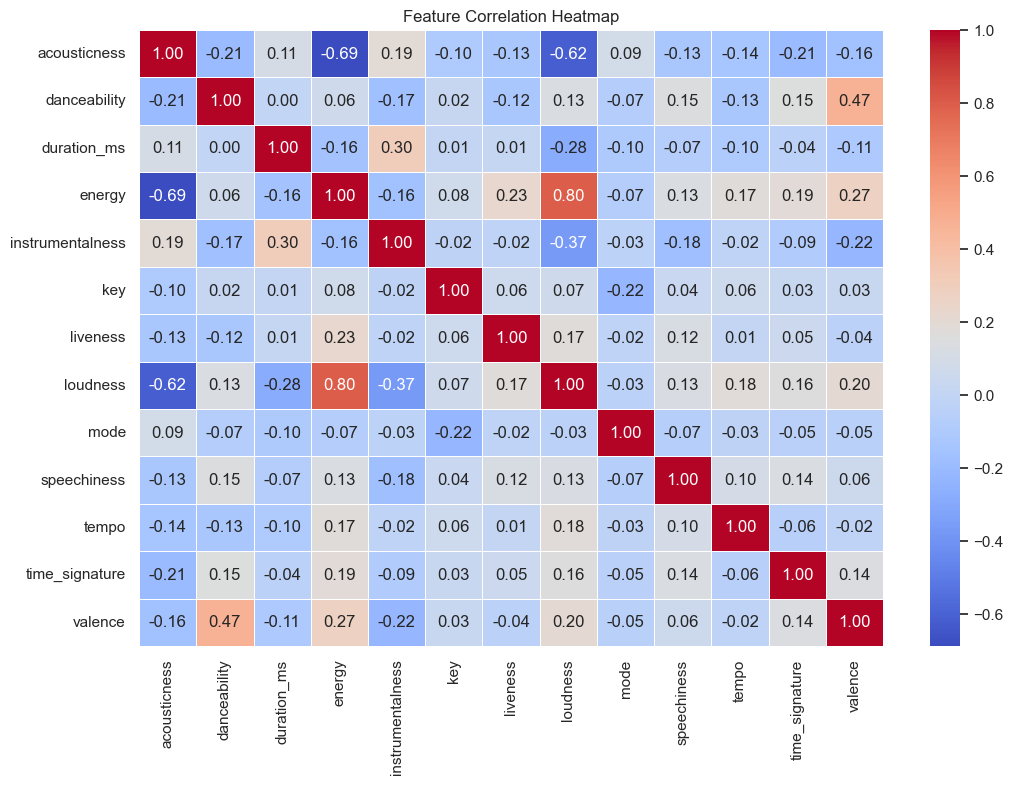

In [82]:
# Exclude "Unnamed: 0" and select only numeric columns
numeric_df = df.select_dtypes(include=['number'])
# Plot correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

### Drop Energy column
Since energy and loudness are highly correlated and energy and acousticness are highly correlated, I will drop energy as we are already getting similar information from the other features.

In [18]:
# Drop energy
df = df.drop(columns=["energy"], errors="ignore")

### Check for null values

In [78]:
# Check for missing values
df.isnull().sum()

acousticness          0
danceability          0
duration_ms           0
energy                0
instrumentalness      0
key                   0
liveness              0
loudness              0
mode                  0
speechiness           0
tempo                 0
time_signature        0
valence               0
song_title            0
artist                0
genre               670
dtype: int64

In [79]:
# Drop rows with any null values
df.dropna(inplace=True)

# Verify that there are no more missing values
print(df.isnull().sum())

acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
time_signature      0
valence             0
song_title          0
artist              0
genre               0
dtype: int64


In [81]:
df.shape

(1347, 16)

We are still left with 1347 songs which is enough to create enough playlists for our purposes.

### Drop duplicate songs
It looks like there are some duplicate songs in the data set. We will keep only one version if it has the same title and artist.

In [25]:
# Drop duplicate songs/ remixes
df = df.drop_duplicates(subset=["song_title", "artist"], keep="first").reset_index(drop=True)

In [24]:
#Check if there are any more duplicates
df.duplicated(subset=["song_title", "artist"], keep=False).sum()

0

In [84]:
df.shape

(1347, 16)

### Select only the features we will use for clustering

In [26]:
# Select relevant features for clustering
cluster_features = ['valence', 'tempo', 'danceability', 'acousticness', 'instrumentalness', 'liveness', 'speechiness','genre']
df_features = df[acoustic_features]

### One Hot Encode Genre

In [100]:
# One-hot encode the 'genre' column (splitting multiple genres)
df_genre_encoded = df["genre"].str.get_dummies(sep=", ")  

# Drop the original 'genre' column
df_encoded = df.drop(columns=["genre"])  

# Merge one-hot encoded genres with the main DataFrame
df_encoded = pd.concat([df_encoded, df_genre_encoded], axis=1)

# Check the updated DataFrame
df_encoded.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,...,uk garage,underground hip hop,urbano latino,vallenato,vaporwave,variété française,vocal jazz,west coast hip hop,witch house,worship
0,0.01020,0.833,204600,0.434,0.021900,2,0.1650,-8.795,1,0.4310,...,0,0,0,0,0,0,0,0,0,0
2,0.03440,0.838,185707,0.412,0.000234,2,0.1590,-7.148,1,0.2890,...,0,0,0,0,0,0,0,0,0,0
3,0.60400,0.494,199413,0.338,0.510000,5,0.0922,-15.236,1,0.0261,...,0,0,0,0,0,0,0,0,0,0
4,0.18000,0.678,392893,0.561,0.512000,5,0.4390,-11.648,0,0.0694,...,0,0,0,0,0,0,0,0,0,0
5,0.00479,0.804,251333,0.560,0.000000,8,0.1640,-6.682,1,0.1850,...,0,0,0,0,0,0,0,0,0,0


### Scale features

In [112]:
# Select only numeric features (exclude non-numeric columns)
features = df_encoded.drop(columns=["song_title", "artist"])  

# Scale the numeric data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(features)

# Convert back to DataFrame
df_scaled = pd.DataFrame(df_scaled, columns=features.columns)

# Preview the scaled data
df_scaled.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,...,uk garage,underground hip hop,urbano latino,vallenato,vaporwave,variété française,vocal jazz,west coast hip hop,witch house,worship
0,-0.684471,1.356704,-0.532518,-1.079860,-0.461356,-0.907413,-0.185677,-0.353991,0.785523,3.771884,...,-0.027257,-0.047246,-0.082015,-0.038561,-0.047246,-0.027257,-0.047246,-0.094809,-0.106119,-0.198373
1,-0.596845,1.386685,-0.751441,-1.177047,-0.535571,-0.907413,-0.224105,0.039029,0.785523,2.186152,...,-0.027257,-0.047246,-0.082015,-0.038561,-0.047246,-0.027257,-0.047246,-0.094809,-0.106119,-0.198373
2,1.465642,-0.676028,-0.592623,-1.503951,1.210593,-0.091831,-0.651938,-1.890994,0.785523,-0.749688,...,-0.027257,-0.047246,-0.082015,-0.038561,-0.047246,-0.027257,-0.047246,-0.094809,-0.106119,-0.198373
3,-0.069636,0.427284,1.649325,-0.518822,1.217444,-0.091831,1.569206,-1.034797,-1.273037,-0.266151,...,-0.027257,-0.047246,-0.082015,-0.038561,-0.047246,-0.027257,-0.047246,-0.094809,-0.106119,-0.198373
4,-0.704061,1.182813,0.009000,-0.523239,-0.536372,0.723751,-0.192082,0.150230,0.785523,1.024770,...,-0.027257,-0.047246,-0.082015,-0.038561,-0.047246,-0.027257,-0.047246,-0.094809,-0.106119,-0.198373


### PCA
Since we have over 300 genres, we will only keep the 10 most important.

In [113]:
# Apply PCA
pca = PCA(n_components=10, random_state=42)  # Adjust components as needed
df_pca = pca.fit_transform(df_scaled)

# Convert back to DataFrame
df_pca = pd.DataFrame(df_pca, columns=[f"PC{i+1}" for i in range(10)])

# Add PCA features back to original dataset
df_final = pd.concat([df[["song_title", "artist"]], df_pca], axis=1)

In [114]:
df_final

,song_title,artist,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,Mask Off,Future,-0.602611,0.319664,-0.192051,-0.216992,-0.019035,-0.554360,-0.210880,-1.087854,-0.206791,-0.111901
2,Xanny Family,Future,0.468591,-2.051392,-0.008488,0.356008,-0.206323,0.128274,-0.379230,0.379587,-0.731407,-0.814549
3,Master Of None,Beach House,-0.459842,-0.230906,-0.741397,-0.376026,-0.083800,-0.755516,-1.711693,3.491079,0.400364,1.476784
4,Parallel Lines,Junior Boys,-0.484547,0.309615,-0.275946,-0.204656,-0.244293,-0.908577,-0.327878,-1.103279,-0.373115,-0.032589
5,Sneakin’,Drake,-0.346928,-0.272258,-0.133129,-0.068580,-0.221366,-0.847196,-0.344491,-1.020149,-0.615232,-0.116029
...,...,...,...,...,...,...,...,...,...,...,...,...
1224,NaN,NaN,-0.155296,-0.166693,-0.285225,-0.063278,-0.062473,-0.494164,0.020957,-0.077786,-0.208965,-0.123680
1225,NaN,NaN,0.063106,-0.427958,-0.069795,-0.027623,-0.035206,-0.395900,-0.026659,-0.133937,-0.377158,-0.328392
1227,NaN,NaN,-0.187716,-0.212239,-0.309706,-0.070132,-0.119320,-0.614528,-0.020366,0.043998,-0.244984,0.159474
1228,NaN,NaN,-0.234620,0.351494,-0.505357,-0.372163,0.070024,-0.527209,-0.035340,0.125373,-0.030861,-0.009453


### Dealing with the NaNs that appeared

In [115]:
df_final.isnull().sum()

song_title    388
artist        388
PC1           388
PC2           388
PC3           388
PC4           388
PC5           388
PC6           388
PC7           388
PC8           388
PC9           388
PC10          388
dtype: int64

In [126]:
df_final.dropna(inplace=True)

## Finding Optimal Number of Clusters

k=2, Inertia=54157.729156840185
k=3, Inertia=45995.547230107644
k=4, Inertia=40973.922970181215
k=5, Inertia=37358.897744410846
k=6, Inertia=30773.43480874131
k=7, Inertia=24579.214583196474
k=8, Inertia=20911.10049201517
k=9, Inertia=18035.031830826872
k=10, Inertia=15183.646126806005


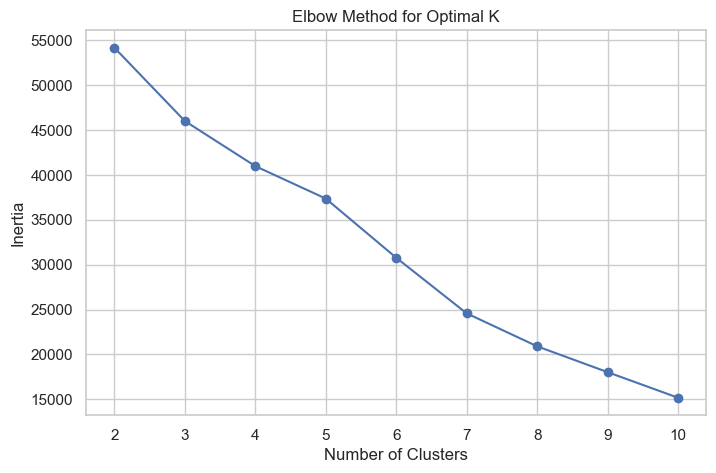

In [129]:
# Determine optimal number of clusters using Elbow method
inertia = []
k_range = range(2, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto', algorithm='elkan')
    kmeans.fit(df_pca)
    inertia.append(kmeans.inertia_)
    print(f'k={k}, Inertia={kmeans.inertia_}')  # Print inertia values

# Plot Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()


The best choice seems to 6 or 7 clusters. Since our goal is to have many, refined playlists, we will start by choosing 7 clusters.

# K Means Clustering - 7 clusters

In [130]:
# Set optimal k
optimal_k = 7

# Train final KMeans model
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto', algorithm='elkan')

# Assign clusters
df["Mood_Cluster"] = kmeans.fit_predict(df_scaled)

In [131]:
df['Mood_Cluster'] = df['Mood_Cluster'].astype(int)

In [132]:
df.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,song_title,artist,genre,Mood_Cluster
0,0.01020,0.833,204600,0.434,0.021900,2,0.1650,-8.795,1,0.4310,150.062,4.0,0.286,Mask Off,Future,rap,0
2,0.03440,0.838,185707,0.412,0.000234,2,0.1590,-7.148,1,0.2890,75.044,4.0,0.173,Xanny Family,Future,rap,0
3,0.60400,0.494,199413,0.338,0.510000,5,0.0922,-15.236,1,0.0261,86.468,4.0,0.230,Master Of None,Beach House,dream pop,0
4,0.18000,0.678,392893,0.561,0.512000,5,0.4390,-11.648,0,0.0694,174.004,4.0,0.904,Parallel Lines,Junior Boys,"alternative dance, indie electronic",0
5,0.00479,0.804,251333,0.560,0.000000,8,0.1640,-6.682,1,0.1850,85.023,4.0,0.264,Sneakin’,Drake,"rap, hip hop",0


In [141]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_pca["PC1"], y=df_pca["PC2"], hue=df_pca["Mood_Cluster"], palette="Set2", alpha=0.7)
plt.title("Clusters Visualized (PCA - First 2 Components)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Mood Cluster")
plt.show()

KeyError: 'Mood_Cluster'

<Figure size 1000x600 with 0 Axes>

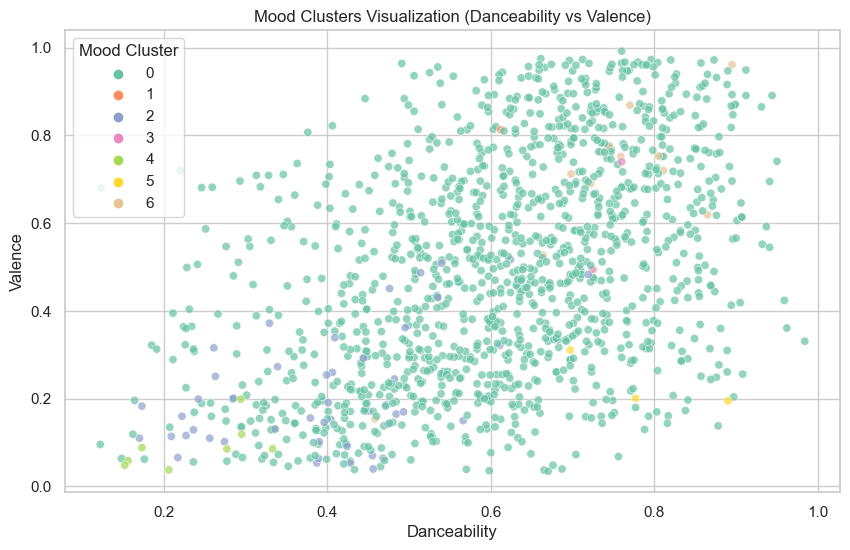

In [133]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df["danceability"], y=df["valence"], hue=df["Mood_Cluster"], palette="Set2", alpha=0.7)
plt.title("Mood Clusters Visualization (Danceability vs Valence)")
plt.xlabel("Danceability")
plt.ylabel("Valence")
plt.legend(title="Mood Cluster")
plt.show()

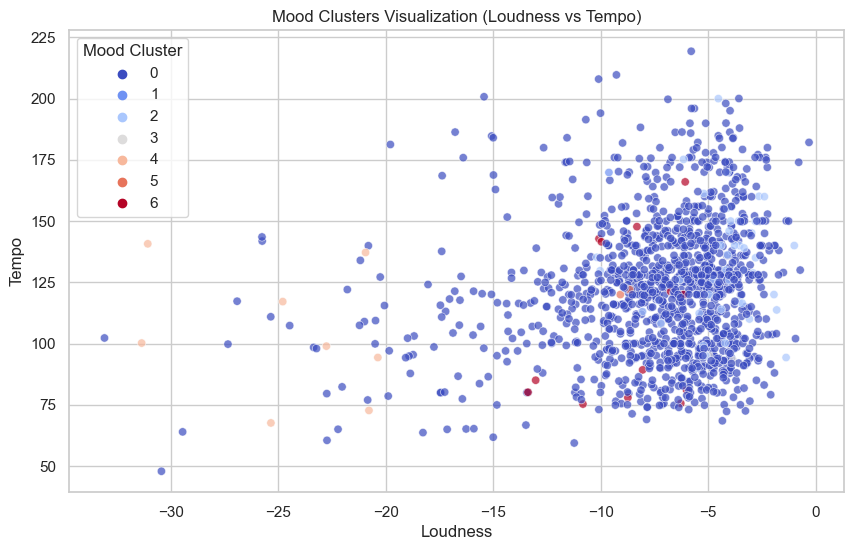

In [134]:
# Scatter plot to visualize clusters based on Loudness & Tempo
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df["loudness"], y=df["tempo"], hue=df["Mood_Cluster"], palette="coolwarm", alpha=0.7)
plt.title("Mood Clusters Visualization (Loudness vs Tempo)")
plt.xlabel("Loudness")
plt.ylabel("Tempo")
plt.legend(title="Mood Cluster")
plt.show()

### Pairplot

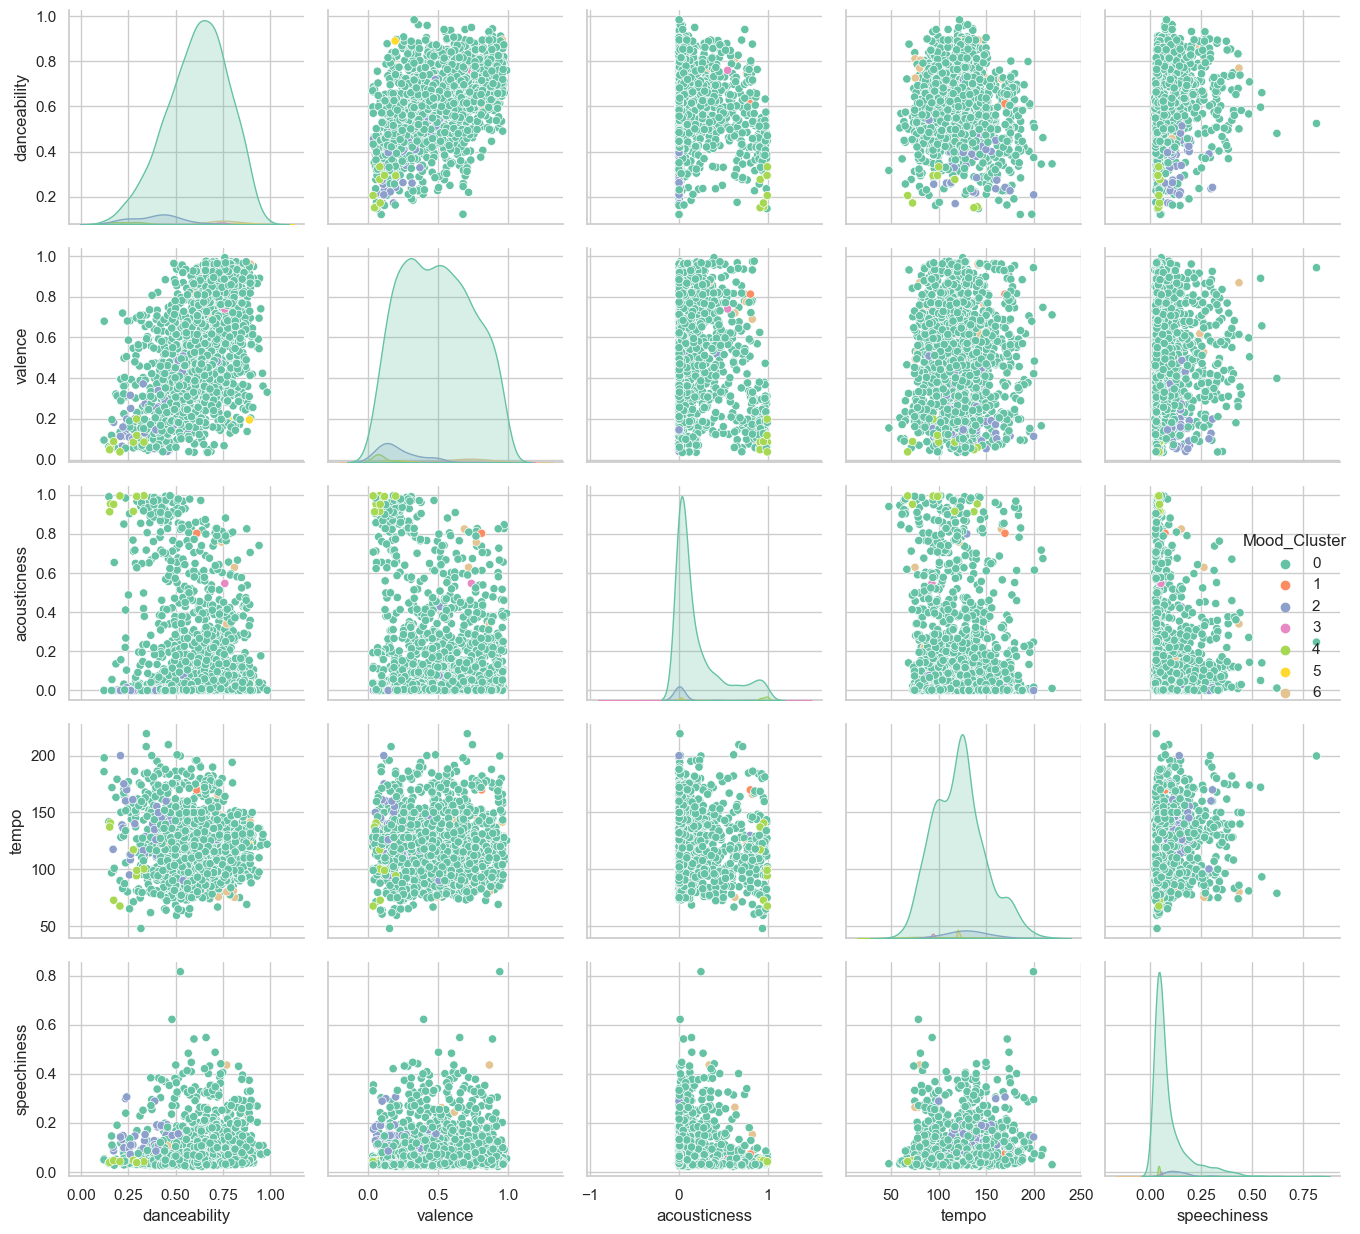

In [135]:
# Convert inf values to NaN and drop them
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

# Select key features for visualization
features = ["danceability", "valence", "acousticness", "tempo", "speechiness"]

# Run pairplot
sns.pairplot(df, vars=features, hue="Mood_Cluster", palette="Set2", diag_kind="kde")
plt.tight_layout()
plt.show()

In [136]:
1️⃣ Are Clusters Well-Separated?
Clusters are highly overlapping, meaning:
The features aren’t strongly differentiating moods.
There might be better features to add, such as lyrics sentiment, genre, or artist popularity.
Exceptions:
Some separation appears in acousticness and speechiness, meaning these may be useful for clustering.
✅ Action: If better separation is needed, consider:

Adding lyrics sentiment scores.
Trying different clustering methods (e.g., Gaussian Mixture Models).
Testing fewer clusters (maybe k=3).
2️⃣ What Do the KDE Plots (Diagonals) Show?
These histograms show how each feature is distributed within clusters:

Danceability & Valence:
Highly overlapping across clusters → Not great differentiators.
Acousticness:
One cluster is heavily skewed toward low values, suggesting a specific mood type (probably energetic/pop songs).
Tempo:
Shows some distribution differences, but not strongly.
Speechiness:
Cluster 4 (pink) is dominant at high speechiness, meaning this cluster may represent rap/spoken word-heavy songs.
✅ Action:

Drop danceability or valence if they don’t contribute much.
Speechiness might be good for detecting rap-heavy clusters.
3️⃣ Feature Relationships (Scatterplots)
Danceability vs. Valence:
Some trend, but not clearly clustered.
Most clusters mix together.
Acousticness vs. Valence:
Low-acousticness songs are mostly in one cluster.
Acoustic songs might be getting their own cluster.
Speechiness vs. Everything:
Cluster 4 (pink) dominates high speechiness → Likely rap-heavy.
✅ Action:

Speechiness and acousticness help separate clusters.
Consider removing or transforming danceability/valence.
🚀 Final Takeaways
Feature	Useful for Clustering?	Action
Danceability	Overlaps a lot	Consider removing
Valence	Overlaps a lot	Consider removing
Acousticness	Some separation	Keep, may help identify calm/acoustic moods
Tempo	Weak separation	Test in combination with others
Speechiness	Strong separation	Keep, helps identify spoken-word songs
✅ Next Steps
Try clustering without danceability/valence.
Add lyrics sentiment or genre encoding.
Test a different clustering approach (GMM or hierarchical clustering).
Let me know if you want deeper insights! 🚀🎵


SyntaxError: invalid character '’' (U+2019) (1659222133.py, line 3)

### Adding genres and lyrics to improve clusters

In [63]:
df[['song_title','artist']]

,song_title,artist
0,Mask Off,Future
1,Redbone,Childish Gambino
2,Xanny Family,Future
3,Master Of None,Beach House
4,Parallel Lines,Junior Boys
...,...,...
1977,Like A Bitch - Kill The Noise Remix,Kill The Noise
1978,Candy,Dillon Francis
1979,Habit - Dack Janiels & Wenzday Remix,Rain Man
1980,First Contact,Twin Moons


In [ ]:
#  Boxplot (Feature Distributions per Cluster - Danceability)
plt.figure(figsize=(12, 6))
sns.boxplot(x="Mood_Cluster", y="danceability", data=df, palette="pastel")
plt.title("Distribution of Danceability Across Clusters")
plt.xlabel("Mood Cluster")
plt.ylabel("Danceability")

In [ ]:
# Violin Plot (Feature Variance per Cluster - Valence)
plt.figure(figsize=(12, 6))
sns.violinplot(x="Mood_Cluster", y="valence", data=df, palette="muted")
plt.title("Valence Distribution Across Mood Clusters")
plt.xlabel("Mood Cluster")
plt.ylabel("Valence")
plt.show()

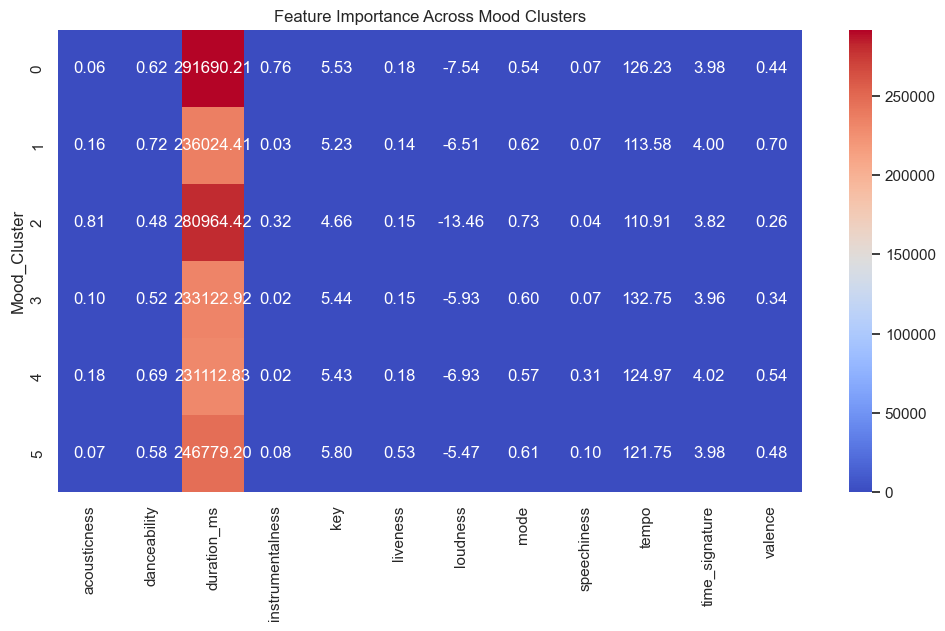

In [36]:
# Select only numeric columns (exclude song titles, artists, etc.)
numeric_cols = df.select_dtypes(include=[np.number]).columns

# Exclude "Mood_Cluster" itself from mean calculation
numeric_cols = [col for col in numeric_cols if col != "Mood_Cluster"]

# Compute the mean for each numeric feature per cluster
cluster_means = df.groupby("Mood_Cluster")[numeric_cols].mean()

# Now plot the heatmap
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.heatmap(cluster_means, cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Feature Importance Across Mood Clusters")
plt.show()

## Silhouette Score - Evaluating the Clusters
Measures how similar a data point is to its own cluster vs. other clusters.

In [139]:
# Evaluate clusters using Silhouette Score
silhouette_avg = silhouette_score(df_pca, df["Mood_Cluster"])
print(f"Silhouette Score: {silhouette_avg:.4f}")

Silhouette Score: -0.2771


# Improving our Clusters

### Try DBSCAN instead of KMeans

In [140]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=1.5, min_samples=5)
df["Mood_Cluster"] = dbscan.fit_predict(df_pca)

silhouette_avg = silhouette_score(df_scaled, df["Mood_Cluster"])
print(f"New Silhouette Score with DBSCAN: {silhouette_avg:.4f}")


New Silhouette Score with DBSCAN: -0.2178


### Try Agglomerative Clustering instead of KMeans

In [40]:
from sklearn.cluster import AgglomerativeClustering

agglo = AgglomerativeClustering(n_clusters=5)
df["Mood_Cluster"] = agglo.fit_predict(df_scaled)

silhouette_avg = silhouette_score(df_scaled, df["Mood_Cluster"])
print(f"New Silhouette Score with Agglomerative Clustering: {silhouette_avg:.4f}")

New Silhouette Score with Agglomerative Clustering: 0.2145


### Try Removing Outliers before Clustering

In [41]:
from sklearn.ensemble import IsolationForest

iso_forest = IsolationForest(contamination=0.05, random_state=42)
outliers = iso_forest.fit_predict(df_scaled)

# Keep only non-outliers
df_cleaned = df[outliers == 1]
df_scaled_cleaned = df_scaled[outliers == 1]

In [42]:
kmeans = KMeans(n_clusters=5, random_state=42, n_init='auto', algorithm='elkan')
df_cleaned["Mood_Cluster"] = kmeans.fit_predict(df_scaled_cleaned)

silhouette_avg = silhouette_score(df_scaled_cleaned, df_cleaned["Mood_Cluster"])
print(f"Silhouette Score after removing outliers: {silhouette_avg:.4f}")


Silhouette Score after removing outliers: 0.2103


C:\Users\hrcoh\AppData\Local\Temp\ipykernel_34052\349517368.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned["Mood_Cluster"] = kmeans.fit_predict(df_scaled_cleaned)


### Take only the Most Important Features

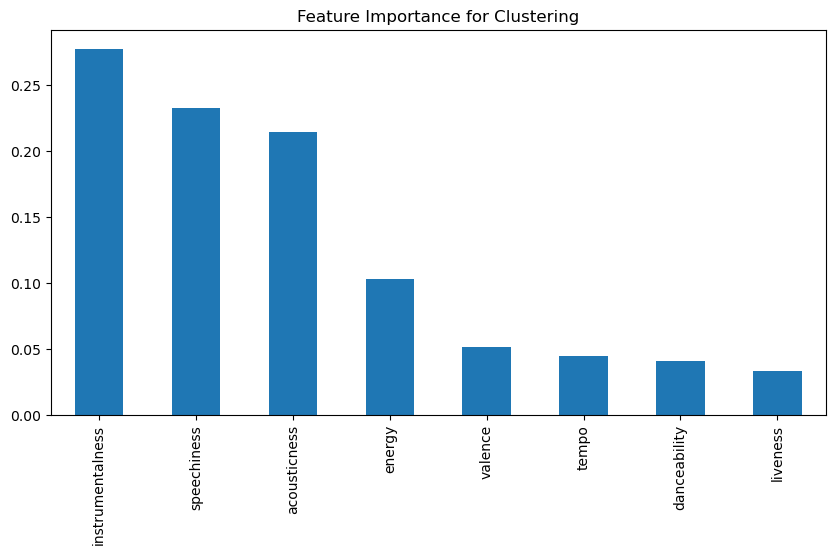

In [25]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import matplotlib.pyplot as plt

# Train a Random Forest Model to find feature importance
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(df_scaled, df["Mood_Cluster"])  # Fit model to clusters

# Use the correct feature names from df_scaled
feature_names = ['valence', 'energy', 'tempo', 'danceability', 'acousticness', 'instrumentalness', 'liveness', 'speechiness']

# Get feature importances
importances = pd.Series(rf.feature_importances_, index=feature_names)

# Plot feature importance
importances.sort_values(ascending=False).plot(kind="bar", figsize=(10, 5), title="Feature Importance for Clustering")
plt.show()


In [26]:
import pandas as pd

# Convert df_scaled back to a DataFrame
df_scaled_df = pd.DataFrame(df_scaled, columns=feature_names)  # Use correct feature names

# Get the top 5 most important features
top_features = importances.nlargest(5).index

# Select only the top features from the scaled DataFrame
df_selected = df_scaled_df[top_features]

# Re-run K-Means on the selected features
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=42, n_init='auto', algorithm='elkan')
df["Mood_Cluster"] = kmeans.fit_predict(df_selected)

# Check the new Silhouette Score
from sklearn.metrics import silhouette_score
silhouette_avg = silhouette_score(df_selected, df["Mood_Cluster"])
print(f"New Silhouette Score after feature selection: {silhouette_avg:.4f}")

New Silhouette Score after feature selection: 0.3020


With 5 clusters, our Silhouette score is still too low. Let's see what the optimal number of clusters is to raise this score.

### After Feature Selection Find Optimal Number of Clusters

Silhouette Score for k=2: 0.3816
Silhouette Score for k=3: 0.2221
Silhouette Score for k=4: 0.2597
Silhouette Score for k=5: 0.3020
Silhouette Score for k=6: 0.3114
Silhouette Score for k=7: 0.2805
Silhouette Score for k=8: 0.2760
Silhouette Score for k=9: 0.2704
Silhouette Score for k=10: 0.2722


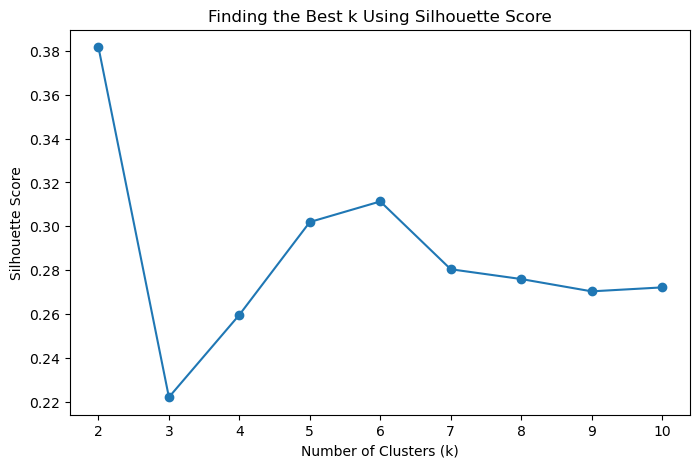

In [27]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt

silhouette_scores = []
k_range = range(2, 11)  # Try from k=2 to k=10

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto', algorithm='elkan')
    clusters = kmeans.fit_predict(df_selected)
    score = silhouette_score(df_selected, clusters)
    silhouette_scores.append(score)
    print(f"Silhouette Score for k={k}: {score:.4f}")

# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(k_range, silhouette_scores, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Finding the Best k Using Silhouette Score")
plt.show()


The optimal number of clusters is 2 according to this graph, but we want more than 2 playlists. We will split into 2 clusters and then from there, make sub clusters.

In [33]:
import skfuzzy as fuzz
import numpy as np

# Define number of clusters
num_clusters = 5  # Adjust if needed

# Run Fuzzy C-Means
cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
    df_selected.T,  # Transpose because FCM expects features as rows
    c=num_clusters,  # Number of clusters
    m=2,             # Fuzziness parameter (higher = softer clustering)
    error=0.005,     # Stopping criterion
    maxiter=1000,    # Max iterations
    init=None
)

# Assign each song to the cluster with the highest probability
df["Mood_Cluster"] = np.argmax(u, axis=0)

# Show probability of belonging to each cluster
df_fc_probs = pd.DataFrame(u.T, columns=[f"Cluster_{i}" for i in range(num_clusters)])
df = pd.concat([df, df_fc_probs], axis=1)

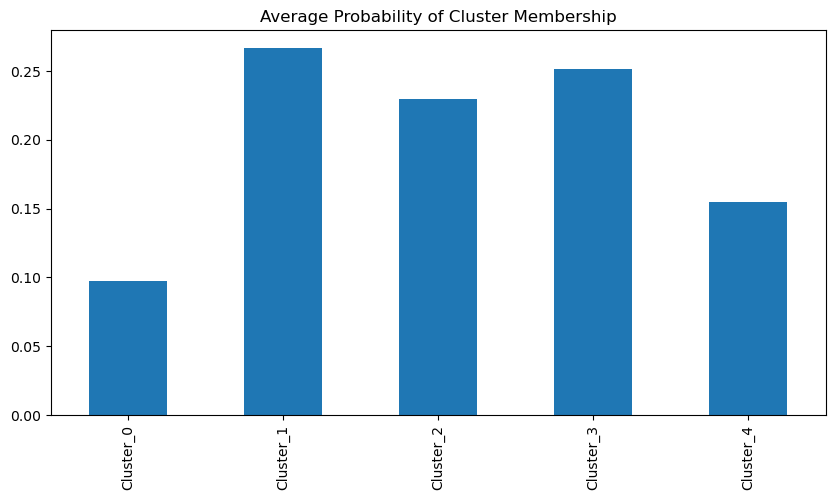

In [34]:
df_fc_probs.mean().plot(kind="bar", figsize=(10, 5), title="Average Probability of Cluster Membership")
plt.show()


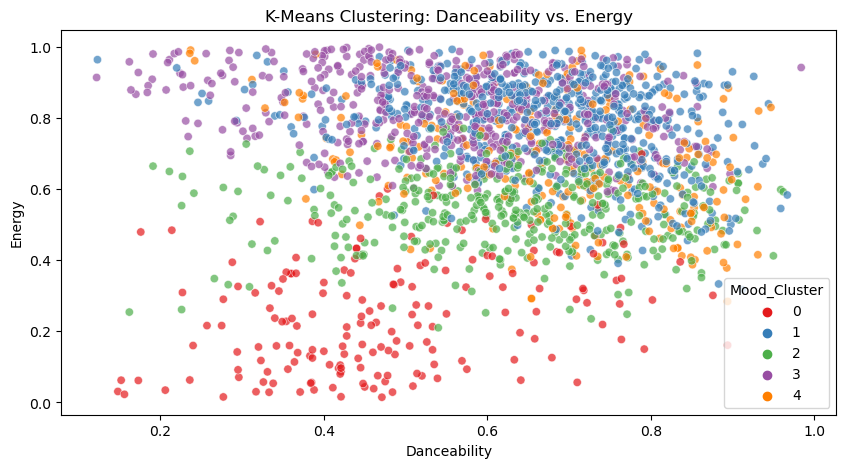

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.scatterplot(x=df["danceability"], y=df["energy"], hue=df["Mood_Cluster"], palette="Set1", alpha=0.7)
plt.title("K-Means Clustering: Danceability vs. Energy")
plt.xlabel("Danceability")
plt.ylabel("Energy")
plt.show()

In [37]:
df[["song_title", "artist", "Mood_Cluster", "Cluster_0", "Cluster_1", "Cluster_2", "Cluster_3", "Cluster_4"]].sample(10)


,song_title,artist,Mood_Cluster,Cluster_0,Cluster_1,Cluster_2,Cluster_3,Cluster_4
637,For Your Love - Club Edit,The Partysquad,2,0.020667,0.114547,0.454762,0.311470,0.098553
1127,Al Filo de Tu Amor,Carlos Vives,1,0.016657,0.712770,0.095377,0.110590,0.064606
706,Can We Go Up?,Paper Diamond,1,0.008047,0.743680,0.097662,0.114963,0.035648
1622,Summer,Marshmello,3,0.022863,0.095374,0.240925,0.587006,0.053832
887,Deeper Than Love,Colleen Green,1,0.135702,0.252778,0.236951,0.200566,0.174004
1399,Summer Night You and I,Standing Egg,0,0.380015,0.144503,0.213156,0.136033,0.126293
1541,Two Sleepy People,Marcus Gilmore,0,0.685512,0.068056,0.096095,0.077829,0.072508
583,Do You Like It? (Feat. Kool A.D),Chaz Van Queen,4,0.061721,0.116849,0.126926,0.116388,0.578116
983,Treat Me Like Fire,LION BABE,2,0.010450,0.055485,0.576115,0.322341,0.035609
1336,The Call of Mighty,Crucify Me Gently,3,0.068176,0.166776,0.230322,0.396009,0.138718


In [38]:
# Get songs that strongly belong to a mood (e.g., at least 0.6 probability)
mood_threshold = 0.6

for i in range(num_clusters):
    print(f"\n🎵 Mood {i} Playlist 🎵")
    display(df[df[f"Cluster_{i}"] > mood_threshold][["song_title", "artist"]].sample(5))


🎵 Mood 0 Playlist 🎵


,song_title,artist
1554,Where Do You Start,Brad Mehldau Trio
1540,Good Morning Heartache,Scott Hamilton
1546,Almas vaggvisa,Jan Lundgren Trio
1542,Can't Help Loving,Beegie Adair
1552,Doubts 2,Ibrahim Maalouf



🎵 Mood 1 Playlist 🎵


,song_title,artist
827,Easy Rider,Action Bronson
1714,Big Time Rush,Big Time Rush
392,Never Never Gonna Give Ya Up,Barry White
1775,"Jumpin', Jumpin'",Destiny's Child
1634,Light It Up (feat. Nyla & Fuse ODG) [Remix],Major Lazer



🎵 Mood 2 Playlist 🎵


,song_title,artist
617,Sweater Weather,The Neighbourhood
1890,What's Up?,4 Non Blondes
998,Father Stretch My Hands Pt. 1,Kanye West
1221,Do I Wanna Know?,Arctic Monkeys
1707,Without Me,Kina Grannis



🎵 Mood 3 Playlist 🎵


,song_title,artist
1504,Confident,Demi Lovato
515,We Own The Sky,M83
1606,Last Chance,Kaskade
1799,Why Can't I?,Liz Phair
288,"The New International Sound, Pt. 2 (feat. M.I.A.)",GENER8ION



🎵 Mood 4 Playlist 🎵


,song_title,artist
588,Oldie,Odd Future
478,Love In Motion - feat. Mayer Hawthorne,Sebastian
792,Tuesday,ILoveMakonnen
1674,Calm Down,G-Eazy
1498,Human,Rag'n'Bone Man


In [ ]:
# How many songs fall into each cluster?
print(df['Mood_Cluster'].value_counts())

In [ ]:
# Select only numeric columns for mean calculation
numeric_cols = df.select_dtypes(include=[np.number]).columns  # Extract numeric columns
numeric_cols = numeric_cols[numeric_cols != "Mood_Cluster"]  # Exclude Mood_Cluster itself

# Compute the mean for each cluster using only numeric features
cluster_means = df.groupby('Mood_Cluster')[numeric_cols].mean()

# Display the results
cluster_means

Feature	High Values Mean...	Low Values Mean...
Valence (0-1)	Happy, cheerful, uplifting	Sad, melancholic
Energy (0-1)	Loud, fast, energetic	Soft, slow, relaxed
Tempo (BPM)	Fast-paced	Slow, chill
Danceability (0-1)	Easy to dance to	Hard to dance to
Acousticness	Acoustic, unplugged feel	Electronic, heavily produced
Liveness	Live performance	Studio recording

In [ ]:
# Manually label clusters based on analysis
mood_labels = {
    0: "Feel Good",
    1: "Workout Pump",
    2: "Calm Cool Collected",
    3: "In my Feels",
    4: "Hype Party"
}

# Add the mood label to the dataset
df["Mood_Label"] = df["Mood_Cluster"].map(mood_labels)

# Show a preview
df[["song_title", "artist", "Mood_Cluster", "Mood_Label"]].head()

## Examples of Songs in Each Playlist

In [ ]:
for cluster in sorted(df["Mood_Cluster"].unique()):
    print(f"\n Mood Cluster {cluster} – {mood_labels[cluster]}")
    display(df[df["Mood_Cluster"] == cluster][["song_title", "artist"]].sample(5))

In [ ]:
# Function to display songs from a selected mood
def display_playlist(mood):
    display(df[df["Mood_Label"] == mood][["song_title", "artist"]].sample(5))

# Create dropdown menu for mood selection
mood_dropdown = widgets.Dropdown(
    options=df["Mood_Label"].unique(),
    description="Choose Mood:",
    style={'description_width': 'initial'}
)

widgets.interactive(display_playlist, mood=mood_dropdown)


In [ ]:
Improve the Mood Classification
If you want to fine-tune how songs are classified, you can:

Re-cluster using different K-Means settings (n_clusters).
Train a classification model (Random Forest, XGBoost) to predict moods based on song features.
Use NLP to analyze song lyrics and improve mood classification.

# Evaluation

# Recommendations

# Conclusion

Actionable Insights:
For streaming platforms: Suggest creating mood-based playlists for improved user engagement.
For artists: Identify mood trends — what emotional tones are dominating popular playlists?